#Widzenie komputerowe
###Projekt 2 - Bilard

In [ ]:
import numpy as np
import cv2
import PIL
import os
import sys
import glob
from pprint import pprint
from ipywidgets import Video
from PIL import Image
from PIL.ExifTags import TAGS

In [ ]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

Wczytanie wybranego fragmentu rozgrywki

In [ ]:
Snooker = cv2.VideoCapture('./Snooker.mp4')

In [ ]:
Video.from_file('Snooker.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x01\x1efmoov\x00\x00\x00lmvhd\x00\x00\…

Działanie algorytmu wykrywająceg bile, na którym opieraja się dalsze etapy projektu zaprezentowane na pojedynczym obrazku.

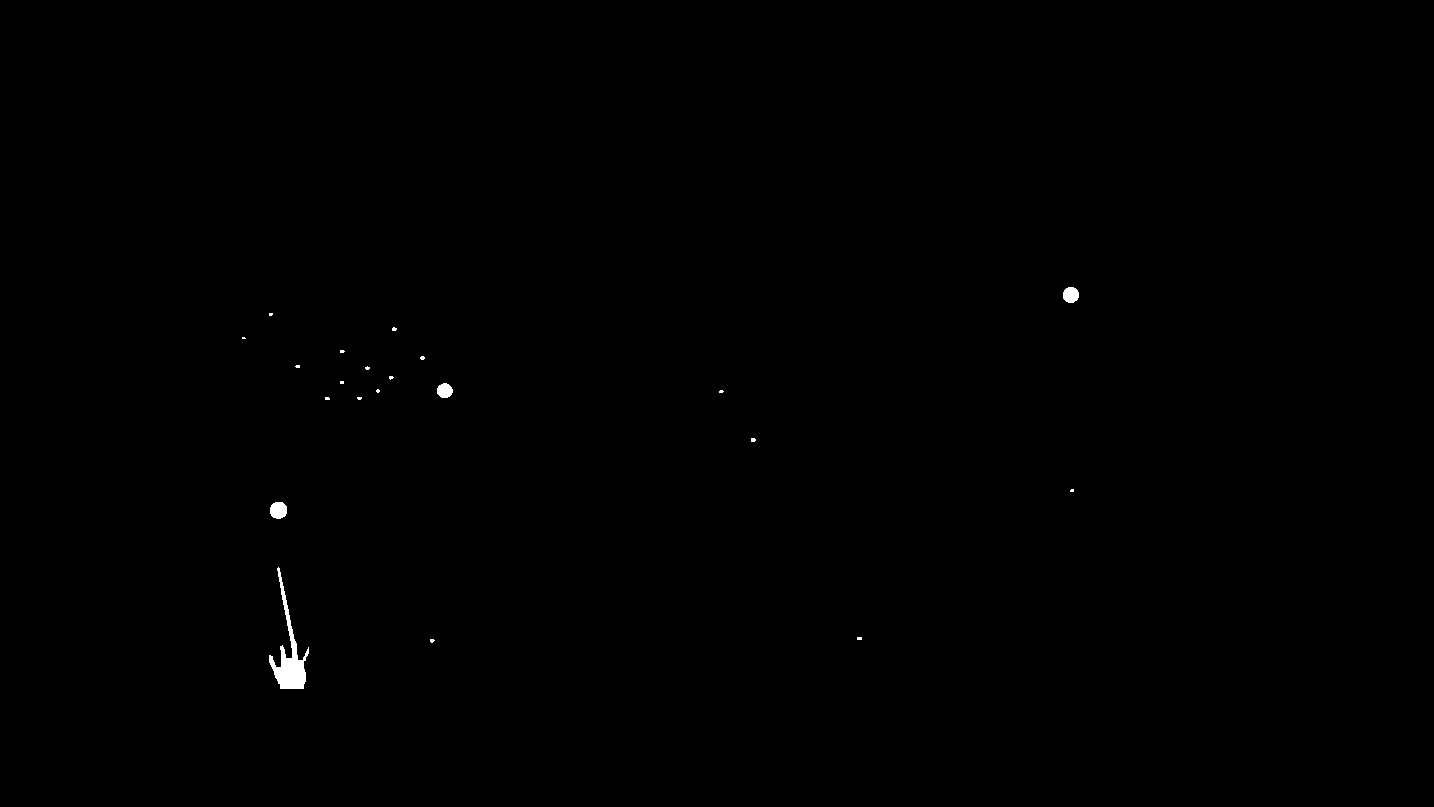

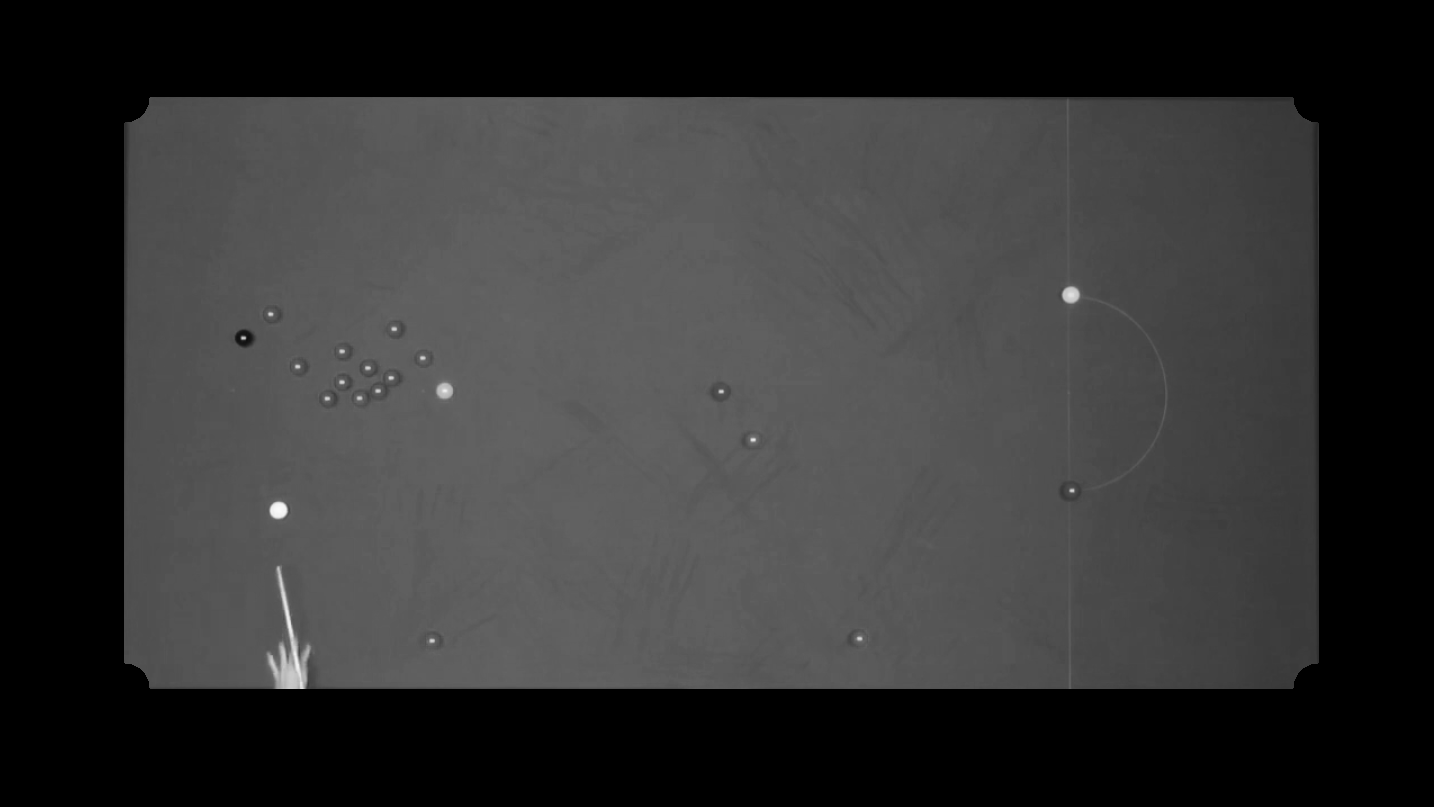

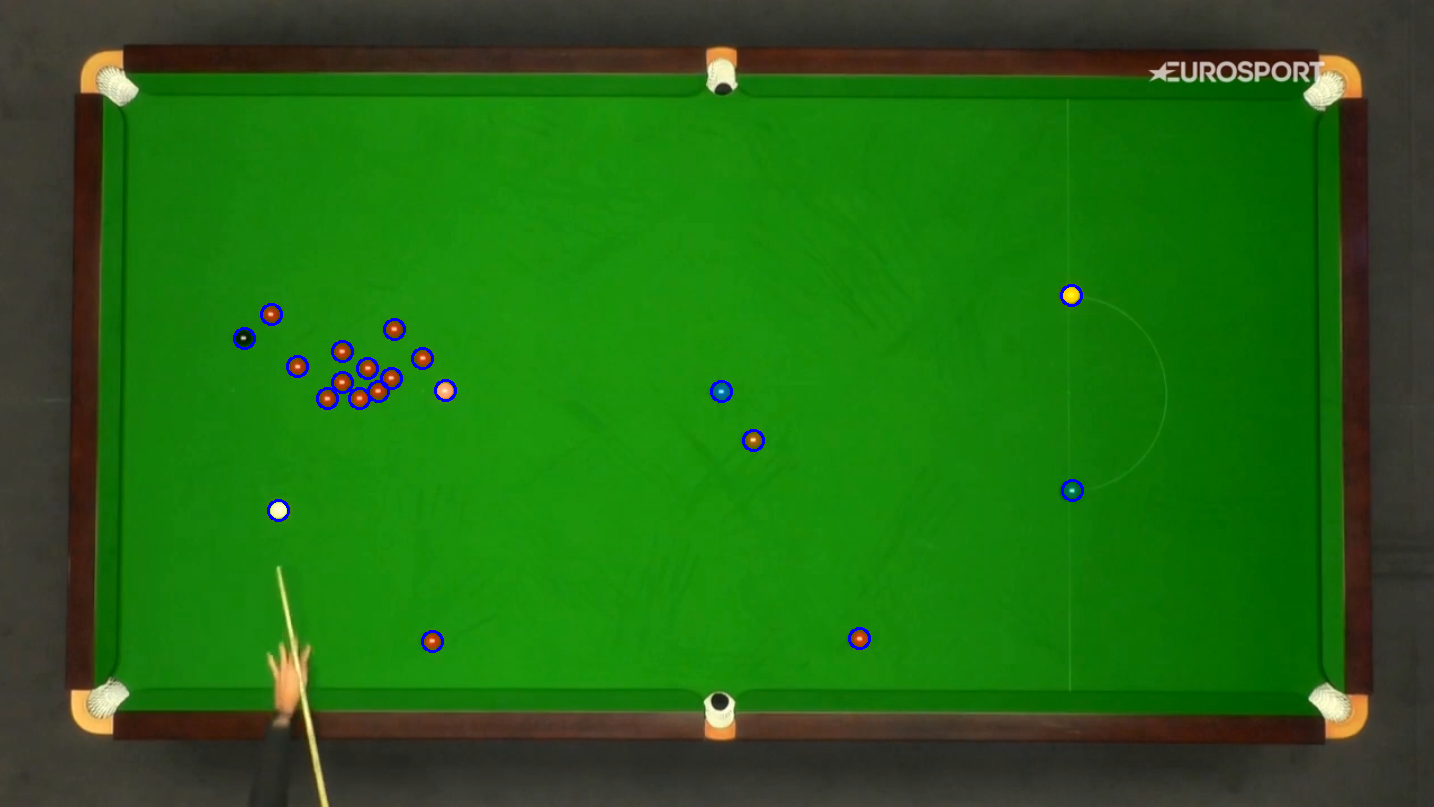

In [ ]:
TL = (124,97)
TR = (1318,97)
BL = (1318,688)
BR = (124,688)

photo = cv2.imread("./withplayer2.png", cv2.IMREAD_COLOR)
H, W, _ = photo.shape

grayscale = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

mask = np.zeros((H, W), dtype=np.uint8)
cv2.fillConvexPoly(mask, np.array([TL, TR, BL, BR]), 1)

cropped = grayscale  * mask

for i in [TL,TR,BL,BR]:
  cropped = cv2.circle(cropped, i, 25, (0,0,0), -1)

bitmap = np.dot((cropped > 160).astype(float),255)

kernel = np.ones((5,5),np.uint8)
bitmap = cv2.morphologyEx(bitmap, cv2.MORPH_CLOSE, kernel)

imshow(bitmap)

_, _, stats, _ = cv2.connectedComponentsWithStats(bitmap.astype(np.uint8), 4, cv2.CV_32S)
stats = np.array(stats[1:])

mask1 = np.logical_and(stats[:,4] < 25, stats[:,4] > 5)
mask2 = np.logical_and(stats[:,4] < 192, stats[:,4] > 182)
mask3 = np.logical_and(stats[:,4] < 213, stats[:,4] > 203)
mask4 = np.logical_and(stats[:,4] < 245, stats[:,4] > 235)
mask = np.logical_or(np.logical_or(mask1,mask2), np.logical_or(mask3,mask4))


stats = stats[mask]

for i in stats:
  x,y,w,h,_=i
  x0=int((x+(x+w))/2) 
  y0=int((y+(y+h))/2)
  photo = cv2.circle(photo, (x0,y0), 10, (255,0,0), 2)

imshow(cropped)
imshow(photo)

In [ ]:
TL = (120,90)
TR = (1170,90)
BL = (1170,610)
BR = (120,610)

# Charakterystyki BGR bil
RED = (47, 99, 184, 'red')
YELLOW = (22, 233, 250, 'yellow')
BLACK = (52, 91, 55, 'black')
PINK = (133, 184, 250, 'pink')
BLUE = (168, 153, 46, 'blue')
WHITE = (201, 254, 249, 'white')
BROWN = (43, 130, 165, 'brown')
GREEN = (103, 158,  43, 'green')

# Lokalizacje łuz
LT_HOLE = (75, 45, 50, 50)
CT_HOLE = (620, 45, 50, 50)
RT_HOLE = (1165, 45, 50, 50)
LB_HOLE = (75, 610, 50, 50)
CB_HOLE = (620, 610, 50, 50)
RB_HOLE = (1165, 610, 50, 50)

# Charakterystyki BGR łuz
LT_BGR = (121, 170, 176)
CT_BGR = (86, 139, 119)
RT_BGR = (87, 124, 157)
LB_BGR = (91, 120, 141)
CB_BGR = (90, 151, 130)
RB_BGR = (119, 181, 182)

Klasa SnookerCV odpowidająca za analizę fragmentu rozgrywki, wykrywanie kul i podliczanie wyników.

In [ ]:
from math import sqrt
import time

class SnookerCV:
  def __init__(self):
    pass
    
  balls = np.array([])
  white_changed_position = False

  HOLES_TRIGGER_ACTIVE = False
  HOLES_TRIGGER_TIMER = 0
  NUMBER_OF_BALLS_MEMORY = (0,0)
  WHITE_BALL_TRIGGER = True

  CURRENT_RED_BALLS = 0
  CURRENT_OTHER_COLOR_BALLS = 0
  RED_COUNTER = 0
  POINTS = 0

  def get_statistics(self):
    print("Number of red ball falls into the pocket: {0}".format(self.RED_COUNTER))
    print("Points (for other color balls fall into the pocket): {0}".format(self.POINTS))
    

  def count_points(self, red, other):
    if other < self.CURRENT_OTHER_COLOR_BALLS:
      self.POINTS += 1
    if red < self.CURRENT_RED_BALLS:
      self.RED_COUNTER += 1
    self.CURRENT_RED_BALLS = red 
    self.CURRENT_OTHER_COLOR_BALLS = other

  def holes_trigger(self, frame, stats, threshold=0.15, timer=30):
    all_clear = True

    for i, j in [(LT_HOLE,LT_BGR),(CT_HOLE,CT_BGR),(RT_HOLE,RT_BGR),(LB_HOLE,LB_BGR),(CB_HOLE,CB_BGR),(RB_HOLE,RB_BGR)]:
      x,y,w,h = i
      m = np.mean(frame[range(y,y+h), range(x,x+w)], axis=0)
      if j[0]*(1-threshold) < m[0] and m[0] < j[0]*(1+threshold) and j[1]*(1-threshold) < m[1] and m[1] < j[1]*(1+threshold) and j[2]*(1-threshold) < m[2] and m[2] < j[2]*(1+threshold):
        continue
      elif not self.HOLES_TRIGGER_ACTIVE:
        self.HOLES_TRIGGER_ACTIVE = True
        cv2.circle(frame, (x,y), 20, (0,255,255), 2)
        r, o = self.count_balls(frame,stats)
        self.count_points(r,o)
        return r,o
      else:
        all_clear = False
    
    if all_clear and self.HOLES_TRIGGER_ACTIVE and self.HOLES_TRIGGER_TIMER < timer:
        self.HOLES_TRIGGER_TIMER += 1
    if self.HOLES_TRIGGER_TIMER == timer:
      self.HOLES_TRIGGER_TIMER = 0
      self.HOLES_TRIGGER_ACTIVE = False

  def get_ball_color(self, frame, x, y, threshold=0.2):
    color = self.get_avg_color(frame, x, y)

    for i in [RED,YELLOW,BLACK,PINK,BLUE,WHITE,BROWN,GREEN]:
      if i[0]*(1-threshold) < color[0] and color[0] < i[0]*(1+threshold) and i[1]*(1-threshold) < color[1] and color[1] < i[1]*(1+threshold) and i[2]*(1-threshold) < color[2] and color[2] < i[2]*(1+threshold):
        return i[3]
    return None
  
  def collision_detection(self, frame, stats, threshold=22):
    if self.balls.size == 0:
      stats = self.get_just_balls(frame, stats, without_white=True)
      self.balls = np.array([(x,y) for x,y,_,_,_ in stats])
    else:
      white = self.check_if_white_ball_visible(frame, stats)
      if white != None:
        x,y = white
        distances = np.array([sqrt((x-a)**2 + (y-b)**2) for a,b in self.balls])
        d = np.argmin(distances)
        if distances[d] < threshold:
          a,b = self.balls[d]
          frame = cv2.circle(frame, (a,b), 20, (0,0,255), 3)
        stats = self.get_just_balls(frame, stats, without_white=True)
        self.balls = np.array([(x,y) for x,y,_,_,_ in stats])

    return frame
        
  def check_if_white_ball_visible(self, frame, stats):
    for i in stats:
      xa,ya,wa,ha,_=i
      xa0=(xa+xa+wa)/2
      ya0=(ya+ya+ha)/2
      color = self.get_ball_color(frame,int(xa0),int(ya0))
      if color == 'white': return (xa0,ya0)
    return None

  def count_balls(self, frame, stats):
    red_balls = 0
    other_color_balls = 0

    for x,y,w,h,_ in stats:
      color = self.get_ball_color(frame,x,y)
      if None: continue
      elif color == 'red':
        red_balls += 1
      else:
        other_color_balls += 1
    
    return red_balls, other_color_balls

  def draw_circle(self, x,y,frame):
    return cv2.circle(frame, (x,y), 10, (255,0,0), 2)

  def get_avg_color(self, frame, x, y, threshold=5):
    return np.mean(frame[range(y-threshold,y+threshold), range(x-threshold,x+threshold)], axis=0)

  def get_just_balls(self, frame, stats, without_white=False):
    just_balls = np.empty((0,5), dtype=np.int8)
    for i in stats:
      x,y,w,h,s=i
      x0=int((x+(x+w))/2) 
      y0=int((y+(y+h))/2)
      color = self.get_ball_color(frame, x0, y0)
      if color != None:
        if without_white == True and color == 'white':
          continue
        else:
          just_balls = np.vstack([just_balls, [x,y,w,h,s]])
    return just_balls

  def __call__(self, frame):
    H, W, _ = frame.shape
    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask = np.zeros((H, W), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.array([TL, TR, BL, BR]), 1)
    cropped = grayscale  * mask

    for i in [TL,TR,BL,BR]:
      cropped = cv2.circle(cropped, i, 25, (0,0,0), -1)

    bitmap = np.dot((cropped > 160).astype(float),255)
    kernel = np.ones((3,3),np.uint8)
    bitmap = cv2.morphologyEx(bitmap, cv2.MORPH_CLOSE, kernel)
    _, _, stats, _ = cv2.connectedComponentsWithStats(bitmap.astype(np.uint8), 4, cv2.CV_32S)
    stats = np.array(stats[1:])
    mask = np.logical_and(stats[:,4] > 5, stats[:,4] < 250)
    stats = stats[mask]

    if not self.check_if_white_ball_visible(frame,stats):
      self.white_changed_position=True

    stats = self.get_just_balls(frame,stats)
    frame = self.collision_detection(frame,stats)
    self.holes_trigger(frame, stats)

    for i in stats:
      x,y,w,h,_=i
      x0=int((x+(x+w))/2) 
      y0=int((y+(y+h))/2)
      frame = self.draw_circle(x0,y0,frame)

    return frame

# Analiza filmu

In [ ]:
if Snooker.isOpened():
    print('Film wczytany!')

W = int(Snooker.get(3))
H = int(Snooker.get(4))

fps = Snooker.get(cv2.CAP_PROP_FPS)
Snooker.set(cv2.CAP_PROP_POS_FRAMES, 0)

video_writer = cv2.VideoWriter('./snooker.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (W, H))
Snooker.set(cv2.CAP_PROP_POS_FRAMES, 0)

SCV = SnookerCV()

while Snooker.isOpened():
    ret, frame = Snooker.read()
    if frame is None: break
    frame = SCV(frame)
    video_writer.write(frame)

SCV.get_statistics()

video_writer.release()

Film wczytany!
Number of red ball falls into the pocket: 4
Points (for other color balls fall into the pocket): 4


In [ ]:
!ffmpeg -hide_banner -loglevel error -i snooker.avi -y free_kick_track.mp4

In [ ]:
Video.from_file('./free_kick_track.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00.\x86[mdat\x00\x00\…

## Wyznaczenie koordynatów łuz i bil

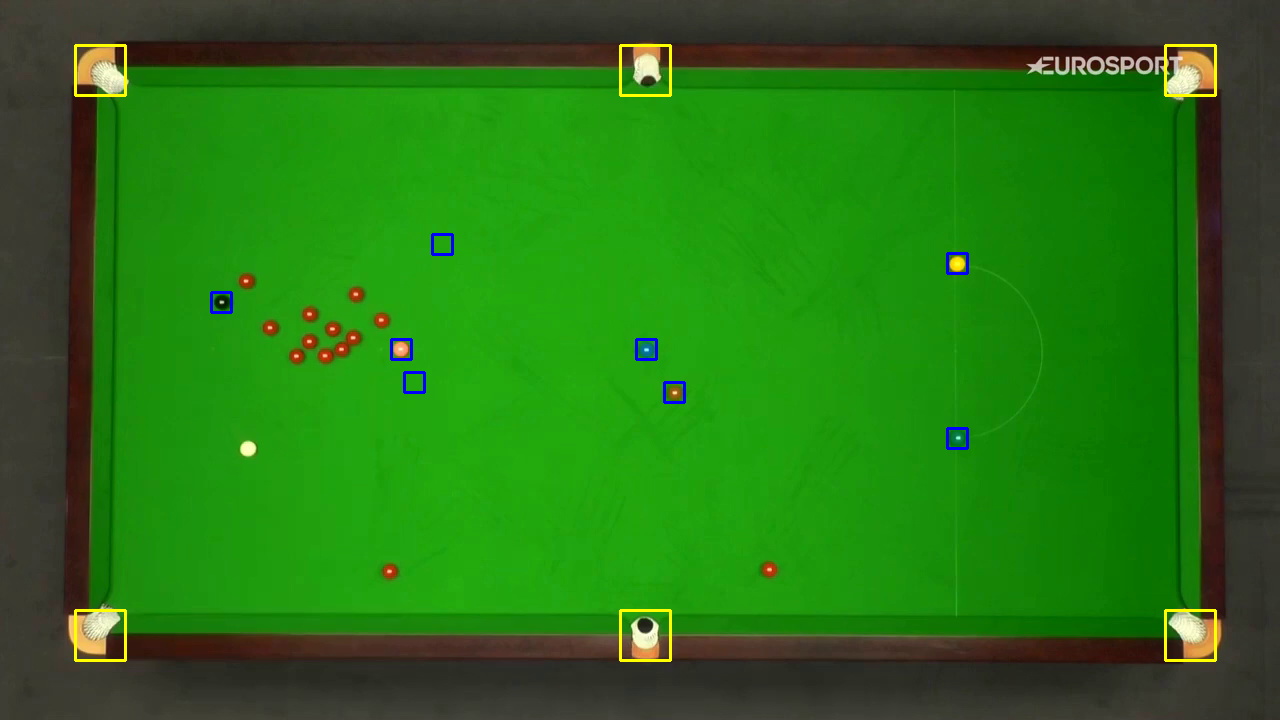

In [ ]:
def draw_bbox(frame, bbox, color=(255, 255, 255)):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame, p1, p2, color, 2, 1)

Snooker.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = Snooker.read()

red_ball = (432, 234, 20, 20)
black_ball = (211, 292, 20, 20)
blue_ball = (636, 339, 20, 20)
white_ball = (404, 372, 20, 20)
ping_ball = (391, 339, 20, 20)
brown_ball = (664, 382, 20, 20)
green_ball = (947, 428, 20, 20)
yellow_ball = (947, 253, 20, 20)

draw_bbox(frame, red_ball, (255, 0, 0))
draw_bbox(frame, black_ball, (255, 0, 0))
draw_bbox(frame, blue_ball, (255, 0, 0))
draw_bbox(frame, white_ball, (255, 0, 0))
draw_bbox(frame, ping_ball, (255, 0, 0))
draw_bbox(frame, brown_ball, (255, 0, 0))
draw_bbox(frame, green_ball, (255, 0, 0))
draw_bbox(frame, yellow_ball, (255, 0, 0))

LT_HOLE = (75, 45, 50, 50)
CT_HOLE = (620, 45, 50, 50)
RT_HOLE = (1165, 45, 50, 50)
LB_HOLE = (75, 610, 50, 50)
CB_HOLE = (620, 610, 50, 50)
RB_HOLE = (1165, 610, 50, 50)

draw_bbox(frame, LT_HOLE, (0, 255, 255))
draw_bbox(frame, CT_HOLE, (0, 255, 255))
draw_bbox(frame, RT_HOLE, (0, 255, 255))
draw_bbox(frame, LB_HOLE, (0, 255, 255))
draw_bbox(frame, CB_HOLE, (0, 255, 255))
draw_bbox(frame, RB_HOLE, (0, 255, 255))


imshow(frame)